/home/julian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


step 1: elapsed 0.9153108596801758
step 2: elapsed 0.011993885040283203
step 3: elapsed 0.00861668586730957
step 4: elapsed 0.24414777755737305
step 5: elapsed 0.002895355224609375
step 5: elapsed 0.0038940906524658203
elapsed 1.1885089874267578


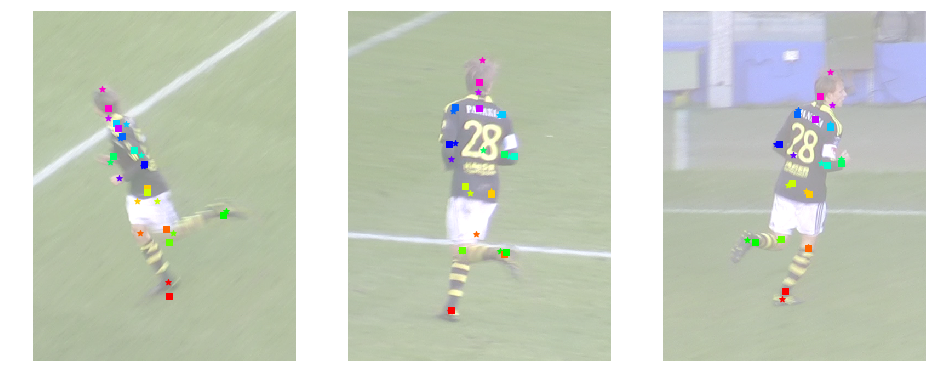

In [1]:
%matplotlib inline
# ---- settings ----
import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.insert(0, '../'); sys.path.insert(0, '../samples')
import paf_loader
import numpy as np
import cv2
from cselect import color as cs
from time import time
import mvpose.data.kth_football2 as kth
from mvpose import pose
import paf_loader

from mvpose.algorithm import settings

params = settings.get_settings(scale_to_mm=1000)

colors = cs.lincolor(16).astype('float32')/255
FRAME = 0
data_root = Settings['data_root']
# seq1_zipname = 'player2sequence1.zip'
# seq1_dir = 'Sequence 1'
seq1_zipname = 'player2sequence1.zip'
seq1_dir = 'Sequence 1'
player = 2
Im, Calib, pos2d, pos3d = kth.get(
    data_root, seq1_zipname, seq1_dir, FRAME, player=player)


from mvpose.algorithm.candidate_selection import project_human_to_2d

heatmaps, pafs = paf_loader.load_confidence_map_and_paf(
    'kth' + seq1_zipname[0:-4], Im, FRAME)
_start = time()
Debug, detections = pose.estimate_heuristic(Calib, heatmaps, pafs,
                                  settings=params, debug=True)
_end = time()
print('elapsed', _end - _start)

Humans = kth.transform3d_from_mscoco(detections)

fig = plt.figure(figsize=(16,10))
for cid, im in enumerate(Im):
    ax = fig.add_subplot(1,3,cid+1); ax.axis('off')
    ax.imshow(im, alpha=0.5)
    joints = pos2d[:,:,cid]
    for jid, (x,y) in enumerate(joints):
        ax.scatter(x,y,color=colors[jid], marker='*')

    for pid, human in enumerate(Humans):
        human2d = project_human_to_2d(human, Calib[cid])
        for jid, p in enumerate(human2d):
            if p is not None:
                ax.scatter(p[0], p[1], color=colors[jid], marker='s')

plt.show()

In [2]:
from mvpose.evaluation import pcp

use_heuristic = True

larms = []
uarms = []
llegs = []
ulegs = []
pelvis = []
shoulder = []
head = []
all_parts = []

for frame in range(0, 210, 5):
    Im, Calib, pos2d, pos3d = kth.get(
        data_root, seq1_zipname, seq1_dir, frame, player=player)
    heatmaps, pafs = paf_loader.load_confidence_map_and_paf(
        'kth' + seq1_zipname[0:-4], Im, frame)
    _start = time()
    if use_heuristic:
        detections = pose.estimate_heuristic(
            Calib, heatmaps, pafs, settings=params)
    else:
        detections = pose.estimate(
            Calib, heatmaps, pafs, settings=params)
    _end = time()
    print('frame ' + str(frame) + ', elapsed', _end - _start)
    
    Humans = kth.transform3d_from_mscoco(detections)
    if len(Humans) > 0:
        assert len(Humans) == 1
        r = pcp.evaluate(pos3d, Humans[0], 0.2)
        larms.append(r.lower_arms)
        uarms.append(r.upper_arms)
        llegs.append(r.lower_legs) 
        ulegs.append(r.upper_legs)
        pelvis.append(r.pelvis)
        shoulder.append(r.shoulder)
        head.append(r.head)
        all_parts.append(r.all_parts)
    else:
        larms.append(0)
        uarms.append(0)
        llegs.append(0) 
        ulegs.append(0)
        pelvis.append(0)
        shoulder.append(0)
        head.append(0)
        all_parts.append(0)

frame 0, elapsed 1.1616709232330322
frame 5, elapsed 1.0265941619873047
frame 10, elapsed 1.3998699188232422
frame 15, elapsed 1.0142786502838135
frame 20, elapsed 1.001490592956543
frame 25, elapsed 0.9776363372802734
frame 30, elapsed 0.981189489364624
frame 35, elapsed 1.0165784358978271
frame 40, elapsed 1.0431358814239502
frame 45, elapsed 1.028660774230957
frame 50, elapsed 0.9851839542388916
frame 55, elapsed 1.0414888858795166
frame 60, elapsed 1.0907237529754639
frame 65, elapsed 1.2320075035095215
frame 70, elapsed 1.1676075458526611
frame 75, elapsed 0.9573326110839844
frame 80, elapsed 0.9970533847808838
frame 85, elapsed 1.084029197692871
frame 90, elapsed 1.1137769222259521
frame 95, elapsed 1.140728235244751
frame 100, elapsed 1.115896224975586
frame 105, elapsed 1.1034867763519287
frame 110, elapsed 1.1343042850494385
frame 115, elapsed 1.1182782649993896
frame 120, elapsed 1.0736303329467773
frame 125, elapsed 1.1587929725646973
frame 130, elapsed 1.1431496143341064
fr

In [4]:
print('lower arms:\t', np.mean(larms))
print('upper arms:\t', np.mean(uarms))
print('lower legs:\t', np.mean(llegs))
print('upper legs:\t', np.mean(ulegs))
print('pelvis:\t\t', np.mean(pelvis))
print('shoulder:\t', np.mean(shoulder))
print('head:\t\t', np.mean(head))
print('all parts:\t', np.mean(all_parts))

lower arms:	 0.42857142857142855
upper arms:	 0.5357142857142857
lower legs:	 0.6071428571428571
upper legs:	 0.5595238095238095
pelvis:		 0.023809523809523808
shoulder:	 0.6904761904761905
head:		 0.0
all parts:	 0.5515873015873015


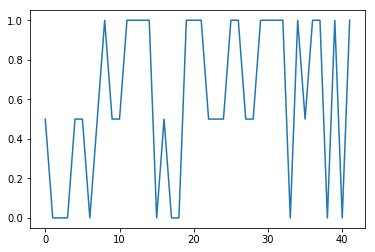

In [7]:
plt.plot(range(len(shoulder)), llegs)